In [50]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

In [51]:
import tarfile

In [52]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [53]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [54]:
datadir = './data/cifar10'
os.listdir(datadir)

['train', 'test', 'labels.txt']

In [55]:
 os.listdir(datadir+'/train')

['deer',
 'airplane',
 'horse',
 'truck',
 'frog',
 'ship',
 'cat',
 'dog',
 'bird',
 'automobile']

In [56]:
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])

test_tf = transforms.Compose([
    transforms.ToTensor()])

In [57]:
dataset = ImageFolder(datadir+'/train', transform = train_tf)
test_ds = ImageFolder(datadir+'/test', transform=test_tf)

In [58]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [59]:
img,label = dataset[0]
print("Image shape: ",img.shape)
print("Label: ",label)
print(img)

Image shape:  torch.Size([3, 32, 32])
Label:  0
tensor([[[0.8627, 0.8706, 0.8784,  ..., 0.8667, 0.8745, 0.8784],
         [0.8588, 0.8627, 0.8706,  ..., 0.8588, 0.8627, 0.8706],
         [0.8627, 0.8706, 0.8784,  ..., 0.8667, 0.8745, 0.8784],
         ...,
         [0.9098, 0.9255, 0.9255,  ..., 0.9020, 0.9098, 0.9216],
         [0.9098, 0.9255, 0.9294,  ..., 0.9020, 0.9098, 0.9216],
         [0.9059, 0.9216, 0.9255,  ..., 0.8549, 0.8706, 0.8784]],

        [[0.9294, 0.9373, 0.9373,  ..., 0.9412, 0.9490, 0.9529],
         [0.9216, 0.9294, 0.9294,  ..., 0.9333, 0.9373, 0.9451],
         [0.9294, 0.9373, 0.9373,  ..., 0.9412, 0.9490, 0.9529],
         ...,
         [0.9451, 0.9451, 0.9490,  ..., 0.9569, 0.9569, 0.9569],
         [0.9451, 0.9451, 0.9451,  ..., 0.9569, 0.9569, 0.9608],
         [0.9412, 0.9412, 0.9412,  ..., 0.9098, 0.9255, 0.9294]],

        [[0.9608, 0.9686, 0.9647,  ..., 0.9686, 0.9765, 0.9804],
         [0.9529, 0.9608, 0.9608,  ..., 0.9608, 0.9647, 0.9725],
         [

Image shape:  torch.Size([3, 32, 32])
Label:  0
Image Class:  airplane


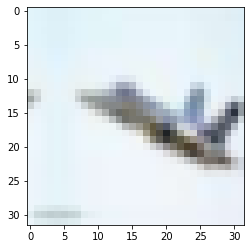

In [60]:
img,label = dataset[0]
print("Image shape: ",img.shape)
print("Label: ",label)
print("Image Class: ",dataset.classes[label])
plt.imshow(img.permute(1,2,0))

## Dataloader


In [61]:
batch_size = 64
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [62]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

## Building the model


In [63]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss, 'val_acc':acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [64]:
class Cifar_transfer(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = models.resnet34(pretrained=True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 10)

  def forward(self,xb):
    out = self.network(xb)
    return out

## Training and Evaluation

In [65]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

## Using GPU

In [66]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [67]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [68]:
device = get_default_device()
device

device(type='cuda')

In [69]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [70]:
model = to_device(Cifar_transfer(), device)

In [71]:
model

Cifar_transfer(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

## Training the model

In [72]:
history = fit(10, 0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 1.0962, val_loss: 1.0774, val_acc: 0.6547
Epoch [1], train_loss: 0.8236, val_loss: 1.0849, val_acc: 0.6367
Epoch [2], train_loss: 0.7172, val_loss: 0.7016, val_acc: 0.7583
Epoch [3], train_loss: 0.6581, val_loss: 0.6759, val_acc: 0.7648
Epoch [4], train_loss: 0.6298, val_loss: 0.8130, val_acc: 0.7577
Epoch [5], train_loss: 0.6083, val_loss: 0.6300, val_acc: 0.7807
Epoch [6], train_loss: 0.5594, val_loss: 0.6239, val_acc: 0.7929
Epoch [7], train_loss: 0.5416, val_loss: 0.6057, val_acc: 0.7921
Epoch [8], train_loss: 0.5005, val_loss: 0.5565, val_acc: 0.8095
Epoch [9], train_loss: 0.4869, val_loss: 0.5693, val_acc: 0.8147


In [73]:
history += fit(5, 0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 0.4603, val_loss: 0.6053, val_acc: 0.8000
Epoch [1], train_loss: 0.5114, val_loss: 0.5542, val_acc: 0.8117
Epoch [2], train_loss: 0.4292, val_loss: 0.5106, val_acc: 0.8315
Epoch [3], train_loss: 0.5321, val_loss: 0.7981, val_acc: 0.7464
Epoch [4], train_loss: 0.4686, val_loss: 0.5627, val_acc: 0.8198


In [77]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [74]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

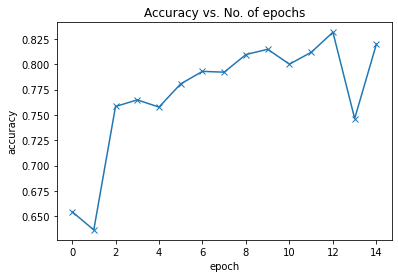

In [78]:
plot_accuracies(history)

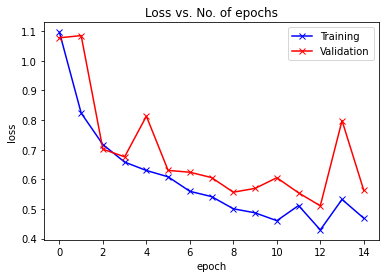

In [79]:
plot_losses(history)

## Evaluating the model with test data



In [80]:
evaluate(model, test_loader)

{'val_acc': 0.8320063948631287, 'val_loss': 0.5095493197441101}

## Saving the model 

In [81]:
torch.save(model.state_dict(), 'cifar10-resnet34.pth')

## Loading the Model and using it for prediction

In [83]:
model2 = to_device(Cifar_transfer(), device)

In [84]:
model2.load_state_dict(torch.load('cifar10-resnet34.pth'))

<All keys matched successfully>

In [86]:
evaluate(model2,test_loader)

{'val_acc': 0.8320063948631287, 'val_loss': 0.5095493197441101}